In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.porter import *
nltk.download('stopwords')
nltk.download('wordnet')

import re
import statistics

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import skew

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\comka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\comka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
training_dataset = pd.read_csv('../../PrimaryDataset/eclipse_preproccessed_whole_dataset.csv')

print('Dimensions of Dataset: ', training_dataset.shape)

Dimensions of Dataset:  (46316, 10)


In [3]:
#Replacing Blank Values with 'NaN' Values
training_dataset.replace("", np.nan, inplace = True)

#Droping Data which has 'Nan' value for 'Description' Column
training_dataset.dropna(subset = ['Description'], inplace = True)

#Checking of any 'NaN' values are present or not.
cond = (training_dataset['Description'] == np.nan)
print('NaN Values after Replacing: ',len(cond))

#Filtering data based on 'Duplicate_Bug_Ids' Column to get Duplicate Bugs
duplicate_test = training_dataset[training_dataset['Duplicate_Bug_Ids'] > 0]
print('Dimensions of Data with Duplicate Bug Ids: ', duplicate_test.shape)

NaN Values after Replacing:  46263
Dimensions of Data with Duplicate Bug Ids:  (3238, 10)


In [4]:
#To Tokenize Data
ted = duplicate_test['Description']

tfidf = TfidfVectorizer()
stemmer = PorterStemmer()

def tokenizer(arg):
    tokens = re.split(r'(\W+)', arg.lower())
    tokens = [
        token for token in tokens
        if re.match('\\w+', token) and not re.match('\\d+', token)
    ]
    
    return list(map(stemmer.stem, tokens))

tfidf.tokenizer = tokenizer
tfidf_matrix_desc = tfidf.fit_transform(ted)

print('Dimensions of Data after Tokenization: ', tfidf_matrix_desc.shape)

Dimensions of Data after Tokenization:  (3238, 13713)


In [5]:
#To calculate Cosine Similarity
tfidf_sim = TfidfVectorizer()

tfidf_matrix = tfidf_sim.fit_transform(ted)

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print('Cosine Similarity Matrix:')
print(cosine_sim)
print('Cosine Similarity Matrix Dimensions: ', cosine_sim.shape)

Cosine Similarity Matrix:
[[1.         0.02579    0.06066968 ... 0.00432633 0.03327533 0.05068615]
 [0.02579    1.         0.04296404 ... 0.02687507 0.05095012 0.07560723]
 [0.06066968 0.04296404 1.         ... 0.01420384 0.07776646 0.0637031 ]
 ...
 [0.00432633 0.02687507 0.01420384 ... 1.         0.03044475 0.02796393]
 [0.03327533 0.05095012 0.07776646 ... 0.03044475 1.         0.08878525]
 [0.05068615 0.07560723 0.0637031  ... 0.02796393 0.08878525 1.        ]]
Cosine Similarity Matrix Dimensions:  (3238, 3238)


In [6]:
#To get Average Cosine Similarity Score
average = np.average(cosine_sim, axis=1)
average_df = pd.DataFrame(average, columns = ['Avg_Sim_Score'])

#To sort Data
average_for_sorting = average_df
sorted_average = average_for_sorting.sort_values(by = 'Avg_Sim_Score', ascending = False)

#To get Skewness Of Distribution
print('Skewness of Distribution: ', skew(average))

#To get Median Of Distribution
median = statistics.median(average)
print('Median of Distribution: ', median)

Skewness of Distribution:  1.0574483302443363
Median of Distribution:  0.04573175864561851


In [7]:
#To add Column in DataFrame
duplicate_test.insert(loc = 7, column = 'Average_Cos_Similarity_Score', value = average_df.values)

similar_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Score'] >= median]
dissimilar_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Score'] < median]

print('Simlar Scores Dataset Dimensions: ', similar_score.shape)
print('Disimlar Scores Dataset Dimensions: ', dissimilar_score.shape)

#To get Average Similarity Scores 
scores = sorted_average['Avg_Sim_Score'].values.tolist()

Simlar Scores Dataset Dimensions:  (1619, 11)
Disimlar Scores Dataset Dimensions:  (1619, 11)


In [8]:
#To get data for BoxPlot

def get_box_plot_data(scores, title):
    scores_df = pd.DataFrame(scores)
    
    labels = ['Scores']
    plt.boxplot([scores], labels = labels)
    plt.ylabel('Cosine Similarity')
    plt.title(title)
    plt.show()
    
    scores_desc = {}
    scores_desc['lower_quartile'] = scores_df.describe().loc['25%']
    scores_desc['median'] = scores_df.describe().loc['50%']
    scores_desc['upper_quartile'] = scores_df.describe().loc['75%']
        
    return pd.DataFrame(scores_desc)

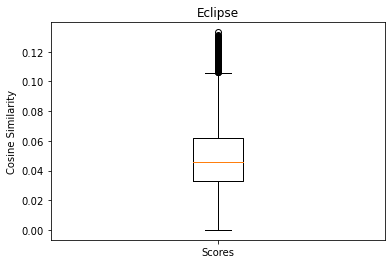

,lower_quartile,median,upper_quartile
0,0.032604,0.045732,0.061941


In [9]:
#To plot Box-Plot
result = get_box_plot_data(scores, 'Eclipse')

#To get Description of Scores
result.head()

In [10]:
#Lower and Upper Limit
lower_limit = result.iloc[0][0]
upper_limit = result.iloc[0][2]

#To Filter data for Similar Bugs
similar_final_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Score'] >= upper_limit]

#To Filter data for Dissimilar Bugs
dissimilar_final_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Score'] <= lower_limit]

print('Dimensions of Filtered Data with Similar Duplicate Bugs: ', similar_final_score.shape)
print('Dimensions of Filtered Data with Dissimilar Duplicate Bugs: ', dissimilar_final_score.shape)

Dimensions of Filtered Data with Similar Duplicate Bugs:  (810, 11)
Dimensions of Filtered Data with Dissimilar Duplicate Bugs:  (810, 11)


# Unigram

In [11]:
#Unigram
unigram_vector = TfidfVectorizer(analyzer='word', ngram_range=(1,1), lowercase=True, min_df=2)

unigram = unigram_vector.fit_transform(ted)

unigram_cosine_sim = cosine_similarity(unigram, unigram)

print('Cosine Similarity Matrix:')
print(unigram_cosine_sim)
print('Cosine Similarity Matrix Dimensions: ', unigram_cosine_sim.shape)

Cosine Similarity Matrix:
[[1.         0.02747156 0.06741182 ... 0.00460842 0.03617896 0.05545536]
 [0.02747156 1.         0.04481647 ... 0.02687507 0.05200523 0.07765789]
 [0.06741182 0.04481647 1.         ... 0.01481625 0.08279929 0.06825199]
 ...
 [0.00460842 0.02687507 0.01481625 ... 1.         0.03107522 0.02872239]
 [0.03617896 0.05200523 0.08279929 ... 0.03107522 1.         0.09308183]
 [0.05545536 0.07765789 0.06825199 ... 0.02872239 0.09308183 1.        ]]
Cosine Similarity Matrix Dimensions:  (3238, 3238)


In [12]:
#To get Average Unigram Cosine Similarity Score
unigram_average = np.average(unigram_cosine_sim, axis=1)
unigram_average_df = pd.DataFrame(unigram_average, columns = ['Avg_Sim_Score'])

#To sort Data
unigram_average_for_sorting = pd.DataFrame(unigram_average_df)
sorted_unigram_average = unigram_average_for_sorting.sort_values(by = 'Avg_Sim_Score', ascending = False)

#To get Skewness Of Distribution
print('Skewness of Distribution: ', skew(unigram_average))

#To get Median Of Distribution
unigram_median = statistics.median(unigram_average)
print('Median of Distribution: ', unigram_median)

#To get Unigram Scores
unigram_scores = sorted_unigram_average['Avg_Sim_Score'].values.tolist()

Skewness of Distribution:  0.9456888348867691
Median of Distribution:  0.05015750877049034


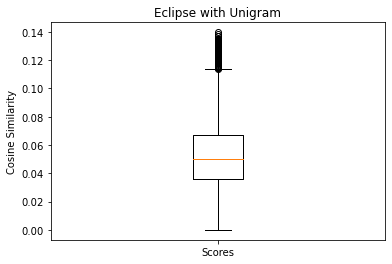

,lower_quartile,median,upper_quartile
0,0.036198,0.050158,0.067285


In [13]:
#To plot Box-Plot
result = get_box_plot_data(unigram_scores, 'Eclipse with Unigram')

#To get Description of Unigram Scores
result.head()

In [14]:
#Lower and Upper Limit
lower_limit = result.iloc[0][0]
upper_limit = result.iloc[0][2]

#To Filter data for Similar Bugs
similar_unigram_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Score'] >= upper_limit]

#To Filter data for Dissimilar Bugs
dissimilar_unigram_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Score'] <= lower_limit]

print('Dimensions of Filtered Data with Similar Duplicate Bugs using Unigram: ', similar_unigram_score.shape)
print('Dimensions of Filtered Data with Dissimilar Duplicate Bugs using Unigram: ', dissimilar_unigram_score.shape)

#Download to csv
similar_unigram_score.to_csv("../../PreProcessedData/Eclipse/Eclipse_textually_similar_unigram_final.csv",index=False)
dissimilar_unigram_score.to_csv("../../PreProcessedData/Eclipse/Eclipse_textually_dissimilar_unigram_final.csv",index=False)

Dimensions of Filtered Data with Similar Duplicate Bugs using Unigram:  (639, 11)
Dimensions of Filtered Data with Dissimilar Duplicate Bugs using Unigram:  (1025, 11)


# Bigram

In [15]:
#Bigram
bigram_vector = TfidfVectorizer(analyzer='word', ngram_range=(1,2), lowercase=True, min_df=2)

bigram = bigram_vector.fit_transform(ted)

bigram_cosine_sim = cosine_similarity(bigram, bigram)

print('Cosine Similarity Matrix:')
print(bigram_cosine_sim)
print('Cosine Similarity Matrix Dimensions: ', bigram_cosine_sim.shape)

Cosine Similarity Matrix:
[[1.         0.02093461 0.03557779 ... 0.00204761 0.02124545 0.03275939]
 [0.02093461 1.         0.0207871  ... 0.01049442 0.0307928  0.03808964]
 [0.03557779 0.0207871  1.         ... 0.00614572 0.04493833 0.03556006]
 ...
 [0.00204761 0.01049442 0.00614572 ... 1.         0.01622357 0.01259854]
 [0.02124545 0.0307928  0.04493833 ... 0.01622357 1.         0.05718869]
 [0.03275939 0.03808964 0.03556006 ... 0.01259854 0.05718869 1.        ]]
Cosine Similarity Matrix Dimensions:  (3238, 3238)


In [16]:
#To get Average Bigram Cosine Similarity Score
bigram_average = np.average(bigram_cosine_sim, axis=1)
bigram_average_df = pd.DataFrame(bigram_average, columns = ['Avg_Sim_Score'])

#To sort Data
bigram_average_for_sorting = bigram_average_df
sorted_bigram_average = bigram_average_for_sorting.sort_values(by = 'Avg_Sim_Score', ascending = False)

#To get Skewness Of Distribution
print('Skewness of Distribution: ', skew(bigram_average))

#To get Median Of Distribution
bigram_median = statistics.median(bigram_average)
print('Median of Distribution: ', bigram_median)

#To get Bigram Scores
bigram_scores = sorted_bigram_average['Avg_Sim_Score'].values.tolist()

Skewness of Distribution:  1.7708793733590487
Median of Distribution:  0.026151756809766287


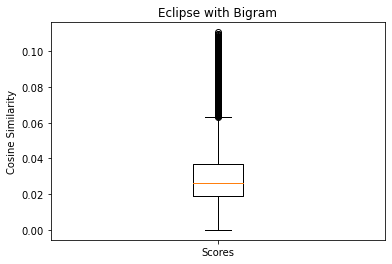

,lower_quartile,median,upper_quartile
0,0.019081,0.026152,0.036747


In [17]:
#To plot Box-Plot
result = get_box_plot_data(bigram_scores, 'Eclipse with Bigram')

#To get Description of Unigram Scores
result.head()

In [18]:
#Lower and Upper Limit
lower_limit = result.iloc[0][0]
upper_limit = result.iloc[0][2]

#To add Column in DataFrame
duplicate_test.insert(loc = 7, column = 'Average_Cos_Similarity_Bigram', value = bigram_average_df.values)

#To Filter data for Similar Bugs
similar_bigram_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Bigram'] >= upper_limit]

#To Filter data for Dissimilar Bugs
dissimilar_bigram_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Bigram'] <= lower_limit]

print('Dimensions of Filtered Data with Similar Duplicate Bugs using Bigram: ', similar_bigram_score.shape)
print('Dimensions of Filtered Data with Dissimilar Duplicate Bugs using Bigram: ', dissimilar_bigram_score.shape)

#Download to csv
similar_bigram_score.to_csv("../../PreProcessedData/Eclipse/Eclipse_textually_similar_bigram_final.csv",index=False)
dissimilar_bigram_score.to_csv("../../PreProcessedData/Eclipse/Eclipse_textually_dissimilar_bigram_final.csv",index=False)

Dimensions of Filtered Data with Similar Duplicate Bugs using Bigram:  (810, 12)
Dimensions of Filtered Data with Dissimilar Duplicate Bugs using Bigram:  (810, 12)


# Trigram

In [19]:
#Trigram
trigram_vector = TfidfVectorizer(analyzer='word', ngram_range=(1,3), lowercase=True, min_df=2)

trigram = trigram_vector.fit_transform(ted)

trigram_cosine_sim = cosine_similarity(trigram, trigram)

print('Cosine Similarity Matrix:')
print(trigram_cosine_sim)
print('Cosine Similarity Matrix Dimensions: ', trigram_cosine_sim.shape)

Cosine Similarity Matrix:
[[1.         0.01678812 0.0304743  ... 0.00167457 0.0184065  0.02913531]
 [0.01678812 1.         0.01578828 ... 0.00761028 0.02365596 0.03003839]
 [0.0304743  0.01578828 1.         ... 0.00476028 0.03687447 0.02995366]
 ...
 [0.00167457 0.00761028 0.00476028 ... 1.         0.01271033 0.01013233]
 [0.0184065  0.02365596 0.03687447 ... 0.01271033 1.         0.04872458]
 [0.02913531 0.03003839 0.02995366 ... 0.01013233 0.04872458 1.        ]]
Cosine Similarity Matrix Dimensions:  (3238, 3238)


In [20]:
#To get Average Of Distribution
trigram_average = np.average(trigram_cosine_sim, axis=1)
trigram_average_df = pd.DataFrame(trigram_average, columns = ['Avg_Sim_Score'])

#To sort Data
trigram_average_for_sorting = trigram_average_df
sorted_trigram_average = trigram_average_for_sorting.sort_values(by = 'Avg_Sim_Score', ascending = False)

#To get Skewness Of Distribution
print('Skewness of Distribution: ', skew(trigram_average))

#To get Median Of Distribution
trigram_median = statistics.median(trigram_average)
print('Median of Distribution: ', trigram_median)

#To get Trigram Scores
trigram_scores = sorted_trigram_average['Avg_Sim_Score'].values.tolist()

Skewness of Distribution:  1.9482169208666797
Median of Distribution:  0.021224629909475573


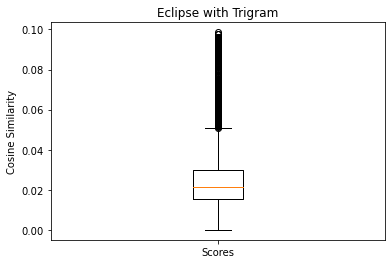

,lower_quartile,median,upper_quartile
0,0.015667,0.021225,0.029742


In [21]:
#To plot Box-Plot
result = get_box_plot_data(trigram_scores, 'Eclipse with Trigram')

#To get Description of Unigram Scores
result.head()

In [22]:
#Lower and Upper Limit
lower_limit = result.iloc[0][0]
upper_limit = result.iloc[0][2]

#To add Column in DataFrame
duplicate_test.insert(loc = 7, column = 'Average_Cos_Similarity_Trigram', value = trigram_average_df.values)

#To Filter data for Similar Bugs
similar_trigram_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Trigram'] >= upper_limit]

#To Filter data for Dissimilar Bugs
dissimilar_trigram_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Trigram'] <= lower_limit]

print('Dimensions of Filtered Data with Similar Duplicate Bugs using Trigram: ', similar_trigram_score.shape)
print('Dimensions of Filtered Data with Dissimilar Duplicate Bugs using Trigram: ', dissimilar_trigram_score.shape)

#Download to csv
similar_trigram_score.to_csv("../../PreProcessedData/Eclipse/Eclipse_textually_similar_trigram_final.csv",index=False)
dissimilar_trigram_score.to_csv("../../PreProcessedData/Eclipse/Eclipse_textually_dissimilar_trigram_final.csv",index=False)

Dimensions of Filtered Data with Similar Duplicate Bugs using Trigram:  (810, 13)
Dimensions of Filtered Data with Dissimilar Duplicate Bugs using Trigram:  (810, 13)


# Comparing Unigram and Bigram

In [23]:
#Comparing Similar Unigram and Bigram
print('Is Similar Unigram and Bigram Data Same?: ', similar_bigram_score['Bug ID'].equals(similar_unigram_score['Bug ID']))

#To convert Data in List
unigram_bug_list = list(similar_unigram_score['Bug ID'])
bigram_bug_list = list(similar_bigram_score['Bug ID'])

#To get Duplicate Bug IDs in Similar Unigram and Bigram Data
count_id = 0
dup_id_in_bug_id = []
for i,v in enumerate(bigram_bug_list):
    if (v in unigram_bug_list):
        count_id +=1
        dup_id_in_bug_id.append(v)
        
print('Duplicate Bug IDs in Similar Unigram and Bigram Data: ', len(dup_id_in_bug_id))

#To get Similar Bigram Data present from Duplicate Bug IDs in Unigram and Bigram List 
new_sim = similar_bigram_score[similar_bigram_score['Bug ID'].isin(dup_id_in_bug_id)]

print('Dimensions of new Data: ', new_sim.shape)

Is Similar Unigram and Bigram Data Same?:  False
Duplicate Bug IDs in Similar Unigram and Bigram Data:  604
Dimensions of new Data:  (604, 12)


In [24]:
#Comparing Dis-similar Unigram and Bigram
print('Is Disimilar Unigram and Bigram Data Same?: ', dissimilar_bigram_score['Bug ID'].equals(dissimilar_unigram_score['Bug ID']))

#To convert Data in List
unigram_dis_bug_list = list(dissimilar_unigram_score['Bug ID'])
bigram_dis_bug_list = list(dissimilar_bigram_score['Bug ID'])

#To get Duplicate Bug IDs in Dissimilar Unigram and Bigram Data
count_id = 0
dup_id_in_bug_id_dis = []
for i,v in enumerate(bigram_dis_bug_list):
    if (v in unigram_dis_bug_list):
        count_id +=1
        dup_id_in_bug_id_dis.append(v)
        
print('Duplicate Bug IDs in Dissimilar Unigram and Bigram Data: ', len(dup_id_in_bug_id_dis))

#To get Dissimilar Bigram Data present from Duplicate Bug IDs in Unigram and Bigram List 
new_dissim = dissimilar_bigram_score[dissimilar_bigram_score['Bug ID'].isin(dup_id_in_bug_id_dis)]

print('Dimensions of new Data: ', new_dissim.shape)

Is Disimilar Unigram and Bigram Data Same?:  False
Duplicate Bug IDs in Dissimilar Unigram and Bigram Data:  763
Dimensions of new Data:  (763, 12)


# Comparing Trigram and Unigram-Bigram

In [25]:
#Comparing Similar Trigram and Unigram-Bigram
print('Is Disimilar Unigram and Bigram Data Same?: ', similar_trigram_score['Bug ID'].equals(new_sim['Bug ID']))

#To convert Data in List
trigram_bug_list = list(similar_trigram_score['Bug ID'])
unigram_bigram_bug_list = list(new_sim['Bug ID'])

#To get Duplicate Bug IDs in Similar Trigram and Unigram-Bigram Data
count_id = 0
dup_id_in_bug_id_tri = []
for i,v in enumerate(trigram_bug_list):
    if (v in unigram_bigram_bug_list):
        count_id +=1
        dup_id_in_bug_id_tri.append(v)
        
print('Duplicate Bug IDs in Similar Trigram and Unigram-Bigram Data: ', len(dup_id_in_bug_id_tri))

#To get Similar Trigram Data present from Duplicate Bug IDs in Trigram and Unigram-Bigram List 
final_new_sim = similar_trigram_score[similar_trigram_score['Bug ID'].isin(dup_id_in_bug_id_tri)]

print('Dimensions of new Data: ', final_new_sim.shape)

Is Disimilar Unigram and Bigram Data Same?:  False
Duplicate Bug IDs in Similar Trigram and Unigram-Bigram Data:  593
Dimensions of new Data:  (593, 13)


In [26]:
#Comparing Dissimilar Trigram and Unigram-Bigram
print('Is Disimilar Trigram and Unigram-Bigram Data Same?: ', dissimilar_trigram_score['Bug ID'].equals(new_dissim['Bug ID']))

#To convert Data in List
trigram_dis_bug_list = list(dissimilar_trigram_score['Bug ID'])
unigram_bigram_dis_bug_list = list(new_dissim['Bug ID'])

#To get Duplicate Bug IDs in Dissimilar Trigram and Unigram-Bigram Data
count_id = 0
dup_id_in_bug_id_dis_tri = []
for i,v in enumerate(trigram_dis_bug_list):
    if (v in unigram_bigram_dis_bug_list):
        count_id +=1
        dup_id_in_bug_id_dis_tri.append(v)
        
print('Duplicate Bug IDs in Dissimilar Trigram and Unigram-Bigram Data: ', len(dup_id_in_bug_id_dis_tri))

#To get Dissimilar Trigram Data present from Duplicate Bug IDs in Trigram and Unigram-Bigram List 
final_new_dissim = dissimilar_trigram_score [dissimilar_trigram_score['Bug ID'].isin(dup_id_in_bug_id_dis_tri)]

print('Dimensions of new Data: ', final_new_dissim.shape)

#Download to csv
final_new_sim.to_csv("../../PreProcessedData/Eclipse/Eclipse_final_sim.csv",index=False)
final_new_dissim.to_csv("../../PreProcessedData/Eclipse/Eclipse_final_dis.csv",index=False)

Is Disimilar Trigram and Unigram-Bigram Data Same?:  False
Duplicate Bug IDs in Dissimilar Trigram and Unigram-Bigram Data:  723
Dimensions of new Data:  (723, 13)


# Textually Similar

In [27]:
#To Drop Duplicates
df_sim = final_new_sim.drop_duplicates(subset = ['Bug ID', 'Summary','Description','Average_Cos_Similarity_Score', 'Average_Cos_Similarity_Bigram', 'Average_Cos_Similarity_Trigram','Duplicate_Bug_Ids' ], keep='first')

print('Dimensions of Data After Dropping Duplicates: ', df_sim.shape)

# Duplicate Pair ( b- & b+)
sim = df_sim[['Bug ID', 'Duplicate_Bug_Ids', 'Average_Cos_Similarity_Trigram']]
sim.reset_index(drop=True, inplace=True)
na = sim.to_numpy()

def createData(training_column, tem_column, col_index):
    s = []
    for i in range(0,df_sim.shape[0]):
        tem = training_dataset.loc[training_dataset[training_column] == na[i, col_index]].copy()
        s.append(str(tem[tem_column].values))
    se = pd.Series(s)
    return se.values

#To add Data in Columns
sim['Summary1'] = createData('Bug ID', 'Summary', 0)
sim['Description1'] = createData('Bug ID', 'Description', 0)
sim['Summary2'] = createData('Bug ID', 'Summary', 1)
sim['Description2'] = createData('Bug ID', 'Description', 1)
sim['is_similar'] = 1

#To show Data
sim.head()

Dimensions of Data After Dropping Duplicates:  (593, 13)


,Bug ID,Duplicate_Bug_Ids,Average_Cos_Similarity_Trigram,Summary1,Description1,Summary2,Description2,is_similar
0,526539.0,522581.0,0.035323,"['Executing an ""ant"" build in a non java proje...",['since having a build xml file in a ...,['Cannot run ant build file from generic proje...,['created attachment screen grab showing err...,1
1,521057.0,517951.0,0.064607,['Internal compiler error: java.lang.NullPoint...,['created attachment source code that causes...,['Internal compiler error: null pointer except...,['it looks like eclipse has trouble with...,1
2,516277.0,517672.0,0.030134,['Exception when launching server'],['created attachment osgi capture since ...,"['Meta File Error, file IO error']",['created attachment orion log this error...,1
3,515243.0,515213.0,0.031674,['Oxygen installation via Eclipse Installer cu...,['created attachment log of eclipse installe...,"['Many mirrors are broken, probably because an...",['created attachment installer log what i d...,1
4,510223.0,457065.0,0.071653,['Error when trying to save using Java editor'],['this suddenly happened when trying to save m...,[],[],1


In [28]:
#To Create a Copy
df_sim_fin = sim.copy()

#To Replace '[]' with '0' 
df_sim_fin['Summary2'] = df_sim_fin['Summary2'].replace(['[]'],'0')
df_sim_fin['Description2'] = df_sim_fin['Description2'].replace(['[]'],'0')

#To Drop rows with '0' value in 'Summary2' Column
df_sim_fin.drop(df_sim_fin.loc[df_sim_fin['Summary2']=='0'].index, inplace=True)

#To Drop rows with '0' value in 'Description2' Column
df_sim_fin.drop(df_sim_fin.loc[df_sim_fin['Description2']=='0'].index, inplace=True)

print('Dimensions of Data after Cleaning: ', df_sim_fin.shape)

Dimensions of Data after Cleaning:  (446, 8)


# Textually Dissimilar

In [29]:
#To Drop Duplicate
df_dissim = final_new_dissim.drop_duplicates(subset = ['Bug ID', 'Summary','Description','Average_Cos_Similarity_Score', 'Average_Cos_Similarity_Bigram', 'Average_Cos_Similarity_Trigram','Duplicate_Bug_Ids' ], keep='first')

print('Dimensions of Data After Dropping Duplicates: ', df_dissim.shape)

# Duplicate Pair ( b- & b+)
dissim = df_dissim[['Bug ID', 'Duplicate_Bug_Ids', 'Average_Cos_Similarity_Trigram']]
dissim.reset_index(drop=True, inplace=True)
na = dissim.to_numpy()

def createDataForDissimilarity(training_column, tem_column, col_index):
    s = []
    for i in range(0,df_dissim.shape[0]):
        tem = training_dataset.loc[training_dataset[training_column] == na[i, col_index]]
        s.append(str(tem[tem_column].values))
    se = pd.Series(s)
    return se.values

#To add Data in Columns
dissim['Summary1'] = createDataForDissimilarity('Bug ID', 'Summary', 0)
dissim['Description1'] = createDataForDissimilarity('Bug ID', 'Description', 0)
dissim['Summary2'] = createDataForDissimilarity('Bug ID', 'Summary', 1)
dissim['Description2'] = createDataForDissimilarity('Bug ID', 'Description', 1)
dissim['is_similar'] = 1

#To show Data
dissim.head()

Dimensions of Data After Dropping Duplicates:  (723, 13)


,Bug ID,Duplicate_Bug_Ids,Average_Cos_Similarity_Trigram,Summary1,Description1,Summary2,Description2,is_similar
0,576714.0,574220.0,0.014654,['Upgrade org.apache.sshd:sshd-core to version...,['affected versions of this package are vulner...,['Apache MINA sshd: update to 2.7.0'],['update the dependency and remove work around...,1
1,513150.0,513149.0,0.013748,['[release] technology.collections 8.1.0'],['we ll use this bug to track the release we ...,['[release] technology.collections 8.1.0'],['we ll use this bug to track the release we ...,1
2,540216.0,539997.0,0.013748,['[release] technology.app4mc 0.9.2'],['we ll use this bug to track the release we ...,['[release] technology.app4mc 0.9.2'],['we ll use this bug to track the release we ...,1
3,542667.0,542532.0,0.013748,['[release] modeling.mmt.qvtd 2018.0.0'],['we ll use this bug to track the release we ...,['[release] modeling.mmt.qvtd 0.17.0'],['we ll use this bug to track the release we ...,1
4,542639.0,542638.0,0.013748,['[release] iot.wakaama 1.0.0'],['we ll use this bug to track the release we ...,['[release] iot.wakaama 1.0.0'],['we ll use this bug to track the release we ...,1


In [30]:
#To Create a Copy
df_dissim_fin= dissim.copy()

#To Replace '[]' with '0' 
df_dissim_fin['Summary2'] = df_dissim_fin['Summary2'].replace(['[]'],'0')
df_dissim_fin['Description2'] = df_dissim_fin['Description2'].replace(['[]'],'0')

#To Drop rows with '0' value in 'Summary2' Column
df_dissim_fin.drop(df_dissim_fin.loc[df_dissim_fin['Summary2']=='0'].index, inplace=True)

#To Drop rows with '0' value in 'Description2' Column
df_dissim_fin.drop(df_dissim_fin.loc[df_dissim_fin['Description2']=='0'].index, inplace=True)

print('Dimensions of Data after Cleaning: ', df_dissim_fin.shape)

Dimensions of Data after Cleaning:  (544, 8)


In [31]:
#To Download Final Processed Data
df_sim_fin.to_csv("../../PreProcessedData/Eclipse/Eclipse_textually_similar_pair.csv")
df_dissim_fin.to_csv("../../PreProcessedData/Eclipse/Eclipse_textually_dissimilar_pair.csv")